In [8]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast

# specify GPU if you have a GPU 
device = torch.device("cuda")


In [9]:
# Lead dataset 
df = pd.read_csv("train.csv")
# mydata.csv has only 2 columns "text" and "label" (binary)
df = df.sample(16000)[['comment_text','toxic']]
df.columns = ['text','label']

In [10]:
df.head()

,text,label
18707,"""\n\n-""""Supernatural"""" has an incorrect pronou...",0
152781,"""\nAboriginal Australians for one. ☎ """,0
66073,While this may have elements of a content disp...,0
69346,"""\n\nI have, to my knowledge, never disallowed...",0
76438,You cocksucker\n\nFUCK YOU OK? I hate you! Sto...,1


In [40]:
# check for class ditribution
print(df['label'].value_counts(normalize = True))


# Split data into train and test 
train_text, temp_text, train_labels, temp_labels = train_test_split(df['text'], df['label'], 
                                                                    random_state=1234, 
                                                                    test_size=0.3, 
                                                                    stratify=df['label'])

# Using temp_text and temp_labels created in previous step generate validation and test set
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=1234, 
                                                                test_size=0.1, 
                                                                stratify=temp_labels)
# This will make 70% training data, 15% validation, and 15% test


0    0.907125
1    0.092875
Name: label, dtype: float64


In [41]:
print(f'train data shape {train_text.shape} , val data shape {val_text.shape} ,test data shape {test_text.shape}')

train data shape (11200,) , val data shape (4320,) ,test data shape (480,)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/m/.cache/pypoetry/virtualenvs/pandas-alt-gDH6xVLf-py3.10/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: Th

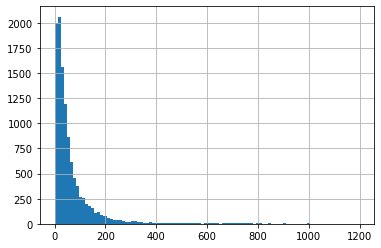

In [42]:

# Import BERT tokenizer from the pretained model 
bert = AutoModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

# Get length of all the sentences in the data
seq_len = [len(i.split()) for i in train_text]
pd.Series(seq_len).hist(bins = 100)

# Select the max_seq_len that we will be keeping based on the distribution above - target 85-90th percentile of text 
max_seq_len = 100

# Tokenize sequences trimmed at max length determined above in the training, validation and testing sets
# tokenize and encode sequences in the 
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# Convert tokens to tensors for train, validation, and test sts
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())



In [43]:
# Create a data loader to prepare data for traiing
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 128

# wrap tensors, random smapler, and prep dataloader for train data 
train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors, random smapler, and prep dataloader for vaidation data 
val_data = TensorDataset(val_seq, val_mask, val_y)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

# freeze all the parameters by setting requires_grad = False 
for param in bert.parameters():
    param.requires_grad = False
    

In [44]:
# Define model architecture
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)
      
      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      
      # apply softmax activation
      x = self.softmax(x)

      return x


# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-3)



# Find class weights and push those to GPU
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(train_labels),
                                        y = train_labels                                                    
                                    )
# class_weights = dict(zip(np.unique(train_labels), class_weights))
# convert class weights to tensor
weights= torch.tensor(class_weights, dtype=torch.float)
weights = weights.to(device)


# define loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 100
print(class_weights)

[0.5511811  5.38461538]


/home/m/.cache/pypoetry/virtualenvs/pandas-alt-gDH6xVLf-py3.10/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [45]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [46]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

In [10]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
         
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'Epoch {epoch + 1}/{epochs}\tTraining Loss: {train_loss:.3f}\tValidation Loss: {valid_loss:.3f}')
    


Evaluating...
Epoch 1/100	Training Loss: 0.573	Validation Loss: 0.427

Evaluating...
Epoch 2/100	Training Loss: 0.417	Validation Loss: 0.358

Evaluating...
Epoch 3/100	Training Loss: 0.394	Validation Loss: 0.498

Evaluating...
Epoch 4/100	Training Loss: 0.408	Validation Loss: 0.359

Evaluating...
Epoch 5/100	Training Loss: 0.386	Validation Loss: 0.608

Evaluating...
Epoch 6/100	Training Loss: 0.398	Validation Loss: 0.341

Evaluating...
Epoch 7/100	Training Loss: 0.373	Validation Loss: 0.333

Evaluating...
Epoch 8/100	Training Loss: 0.349	Validation Loss: 0.330

Evaluating...
Epoch 9/100	Training Loss: 0.454	Validation Loss: 0.381

Evaluating...
Epoch 10/100	Training Loss: 0.379	Validation Loss: 0.523

Evaluating...
Epoch 11/100	Training Loss: 0.381	Validation Loss: 0.321

Evaluating...
Epoch 12/100	Training Loss: 0.345	Validation Loss: 0.572

Evaluating...
Epoch 13/100	Training Loss: 0.357	Validation Loss: 0.377

Evaluating...
Epoch 14/100	Training Loss: 0.351	Validation Loss: 0.415



In [48]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

# get predictions for test data
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()
  
  
# model's performance
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))
pd.crosstab(test_y, preds)

              precision    recall  f1-score   support

           0       0.98      0.90      0.94       435
           1       0.45      0.82      0.58        45

    accuracy                           0.89       480
   macro avg       0.72      0.86      0.76       480
weighted avg       0.93      0.89      0.90       480



col_0,0,1
row_0,,
0,390,45
1,8,37


In [49]:
import torch as tc
print(tc.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 1            |        cudaMalloc retries: 2         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  432888 KB |    7460 MB |  126546 MB |  126124 MB |
|       from large pool |  432384 KB |    7459 MB |  126348 MB |  125925 MB |
|       from small pool |     504 KB |       3 MB |     198 MB |     198 MB |
|---------------------------------------------------------------------------|
| Active memory         |  432888 KB |    7460 MB |  126546 MB |  126124 MB |
|       from large pool |  432384 KB |    7459 MB |  126348 MB |